In [4]:
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn import metrics
from sklearn.metrics import accuracy_score

import nltk
from nltk.stem import WordNetLemmatizer

import xgboost as xgb

### Data import

In [5]:
train = pd.read_json('cooking_train.json')
test = pd.read_json('cooking_test.json')

### Overview

In [3]:
train.head()

,cuisine,id,ingredients
0,chinese,29565,"[romaine lettuce, sliced almonds, vegetable oi..."
1,italian,15528,"[pistachios, dried fig, bread ciabatta, extra-..."
2,cajun_creole,38015,"[olive oil, lemon, chili sauce, shrimp, butter..."
3,italian,20511,"[fresh basil, olive oil, potato gnocchi, garli..."
4,chinese,44111,"[honey, portabello mushroom, tamari soy sauce,..."


In [4]:
print 'train shape= ', train.shape
print 'test shape = ', test.shape
print 'set of cuisines = ', sorted(set(train.cuisine))
print '# of cuisines = ', len(set(train['cuisine']))
print 'type of cuisines', type(train['cuisine'][0])
print 'type of ingredients column:', type(train['ingredients'][0])
print 'type of ingredient entry:', type(train['ingredients'][0][0])

train shape=  (30000, 3)
test shape =  (9774, 2)
set of cuisines =  [u'brazilian', u'british', u'cajun_creole', u'chinese', u'filipino', u'french', u'greek', u'indian', u'irish', u'italian', u'jamaican', u'japanese', u'korean', u'mexican', u'moroccan', u'russian', u'southern_us', u'spanish', u'thai', u'vietnamese']
# of cuisines =  20
type of cuisines <type 'unicode'>
type of ingredients column: <type 'list'>
type of ingredient entry: <type 'unicode'>


##### Overview conclusions

Train set consists of 30k examples. Each example defines some recipe and is represented by a list of ingredients ('ingredients', list of unicode entries) and labelled by cuisine origin ('cuisine', unicode entry).

Test set consists of 9,774 examples so ca. 1/3 of train set.

This is a multi-class classification problem: we are supposed to predict one of 20 cuisine origins given test set ingredients' lists.

To properly transform the representation of ingredients seems to be the major challenge.

### First round problem inspection

#### Target data inspection

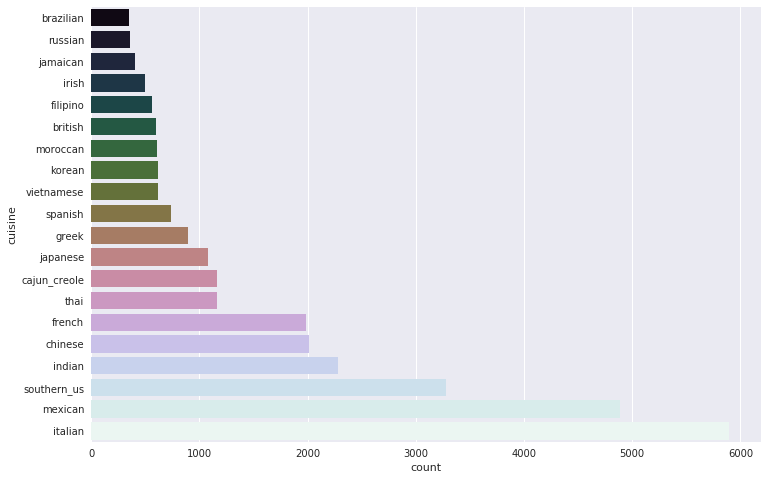

In [5]:
# Labels countplot
sns.set(rc={'figure.figsize':(12,8)})
order = train['cuisine'].value_counts(ascending=True).index
sns.countplot(y='cuisine', data = train, palette="cubehelix", order=order)

##### Target data inspection conclusions
Certain sort of cuisines (like Italian or Mexican) are overrepresented in the train set.  This most likely reflects the non-uniform popularity of cuisines.

#### Ingredients data inspection
Some first-glance observations:
* ingredient lists are of varying length
* each ingredient is an English phrase (mostly noun with some attributives)
* some attributives of ingredients link with "national origins" (be it true or not)
  * 'Italian bread' appears mostly in Italian cuisine but also in Cajun-Creole, Spanish etc
  * 'french fries' appears in Korean, British, Vietnamese etc recipes but quite infrequent in French (if at all - to be checked eventually)
  * some ingredients are very popular, other are rare and peculiar
  
Few examples of peculiar ingredients:
* "cura\u00e7ao"
* "Ni\u00e7oise olives"
* "kahl\u00faa"
* "Country Crock\u00ae Spread"
* "I Can't Believe It's Not Butter!\u00ae Spread"
* "Spring! Water"
* "Truv\u00eda\u00ae natural sweetener",
* "2 1/2 to 3 lb. chicken, cut into serving pieces",


 
It seems that we can one-hot encode at following different levels:
 1. phrase level: simply one-hot encode each ingredient 
 2. token level: one-hot encode each token
 3. (optionally) mixed level: some more fancy way
  

#### General idea

My presumption is that:
* super-popular ingredients are meaningless wrt prediction
* some tokens (like adjectives, numbers) are meaningless wrt predictions
* super-rare ingredients are ignorable wrt overall score
* there is a subset of ingredients that really makes a difference here

##### Number of different ingredients

In [6]:
# First let's check how many different ingredients there are
set_of_ingredients = set()
for i in range(train.shape[0]):
    set_of_ingredients = set_of_ingredients | set(train['ingredients'][i])

print('# of different ingredients = ', len(set_of_ingredients))

('# of different ingredients = ', 6251)


Oooops ... 6251 is quite a LOT of different ingredients. Fortunately we have 30k training examples.

##### Cuisine vs recipe length

In [7]:
train.assign(length=0)
train['length'] = train.apply(lambda row: len(row['ingredients']) , axis = 1)

In [9]:
train.head()

,cuisine,id,ingredients,length
0,chinese,29565,"[romaine lettuce, sliced almonds, vegetable oi...",17
1,italian,15528,"[pistachios, dried fig, bread ciabatta, extra-...",8
2,cajun_creole,38015,"[olive oil, lemon, chili sauce, shrimp, butter...",15
3,italian,20511,"[fresh basil, olive oil, potato gnocchi, garli...",19
4,chinese,44111,"[honey, portabello mushroom, tamari soy sauce,...",14


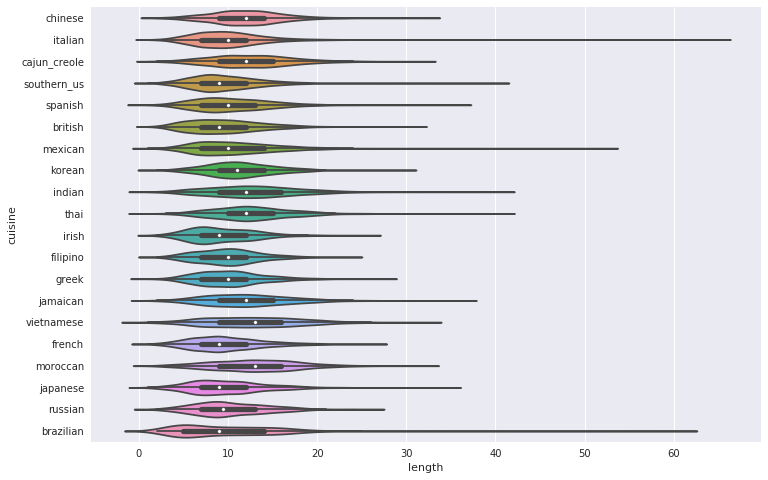

In [9]:
sns.violinplot(y=train['cuisine'], x=train['length'])

We can observe there are some differences across cuisines wrt recipe ingredients list length. It might be beneficiary to add 'length' column to our model.

##### Remarks
In my experiments adding 'length' column didn't make a difference. So I skip it in further considerations.

### Preprocessors

##### Unusual reqierements

In [ ]:
nltk.download('wordnet')

##### Default  prepocessor

In [10]:
# default token-based preporcessor
def default_preprocessor(line):
    return ' '.join(line).lower()

# create vecotrizer
# vectorizer = CountVectorizer(preprocessor=token_preprocessor)
# term_matrix = vectorizer.fit_transform(train['ingredients']).todense()
# print("# tokens is ", len(vectorizer.get_feature_names()))

('# tokens is ', 2866)


There are 2866 different tokens which is ca 45% of # different ingredients.

##### Phrase-level preprocessor

In [1]:
def phrase_preprocessor(line):
    return ' '.join([el.replace(' ','') for el in line ]).lower()

# # create vecotrizer
# vectorizer = CountVectorizer(preprocessor=phrase_preprocessor)
# term_matrix = vectorizer.fit_transform(train['ingredients']).todense()
# print("# phrasess is ", len(vectorizer.get_feature_names()))

There are 6315 different phrases which is somehow approximately in line with our previous calculations of different ingredients - I guess some typos make a difference here.

##### Hand-crafted preprocessor

In [2]:
def remove_special(word):
    word = word.replace('&', '').replace('(', '').replace(')','')
    word = word.replace('\'', '').replace('\\', '').replace(',','')
    word = word.replace('.', '').replace('%', '').replace('/','')
    word = word.replace('"', '')

    return word

In [10]:
# default token-based preporcessor
stemmer = SnowballStemmer("english")
def token_preprocessor(line):
    # transform to lowercase
    line = [ word.lower() for word in line ]
    # remove special characters
    line = [ remove_special(word) for word in line ]
    # remove digits and stem
    line = [ stemmer.stem(word) for word in line if not word.isdigit() ]
    return ' '.join(line).lower()

I want to remove the following tokens:

In [7]:
popular_nouns = ["salt", "onion", "olive oil", "water", "garlic", 
                         "sugar", "garlic cloves", "butter", "pepper"]
popular_adjectives = ["unsalted", "fresh", "large", "ground", "light", "brown", "dark"]
popular_colors = ["red", "green", "yellow", "white"]
misc = ["heavy", "juice", "milk", "oil", "eggs", "chicken", 
        "tomato", "powder", "all-purpose flour", "double", 
        "instant", "better", "lesser", "powdered", "sliced", "diced", "seeds", 
        "seed", "crispy", "style", "plain", "fat", "fish", "gold", "golden", "potatoes"]

In [8]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(popular_nouns, popular_adjectives, 
                                              popular_colors, misc)

In [11]:
# Vectorizers definitions
tfidf_vectorizer = TfidfVectorizer(preprocessor=token_preprocessor, 
                                   stop_words=my_stop_words, min_df = 20)
count_vectorizer = CountVectorizer(preprocessor=token_preprocessor, 
                                   stop_words=my_stop_words, min_df = 20)

In [13]:
# split train set into X and y
X = train['ingredients']
y = train['cuisine']

In [14]:
# Vectorizers fitting
tfidf_matrix = tfidf_vectorizer.fit_transform(X).todense()
count_matric = count_vectorizer.fit_transform(X).todense()

In [15]:
print "count vectorizer length = ", len(count_vectorizer.vocabulary_)
print "tfidf vectorizer length = ", len(tfidf_vectorizer.vocabulary_)

count vectorizer length =  977
tfidf vectorizer length =  977


### Model 1
#### Soft voting with dominating Extra Tree Classifier + RF + SGD + Ada

In [16]:
# Pipelines
pipelines = {}

pipelines['etc'] = Pipeline([
        ('vectorizer', TfidfVectorizer(preprocessor=token_preprocessor, 
                                   stop_words=my_stop_words, min_df = 10)),
        ('classifier', ExtraTreesClassifier(n_estimators=300))        
    ])

pipelines['rfc'] = Pipeline([
        ('vectorizer', TfidfVectorizer(preprocessor=token_preprocessor, 
                                   stop_words=my_stop_words, min_df = 10)),
        ('classifier', RandomForestClassifier(n_estimators=300))        
    ])

pipelines['sgd'] = Pipeline([
        ('vectorizer', TfidfVectorizer(preprocessor=token_preprocessor, 
                                   stop_words=my_stop_words, min_df = 10)),
        ('classifier', SGDClassifier(max_iter = 10, loss='log'))        
    ])

pipelines['ada'] = Pipeline([
        ('vectorizer', TfidfVectorizer(preprocessor=token_preprocessor, 
                                   stop_words=my_stop_words, min_df = 10)),
        ('classifier', AdaBoostClassifier(n_estimators=200))        
    ])

In [17]:
clf_list = [('etc', pipelines['etc']), ('rfc', pipelines['rfc']), 
            ('sgd', pipelines['sgd']), ('ada', pipelines['ada'])]
votc = VotingClassifier(estimators= clf_list, voting='soft', weights=[2,1,1,1])

In [18]:
voting_scores = {}
voting_scores = cross_val_score(votc, X, y, cv=2)
print voting_scores

/usr/lib64/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[ 0.75143314  0.75156688]


### Model 2
##### Pure SGD with modified hubner loss
Modified Hubner loss seemed to make a difference.

In [ ]:
sgd_pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer(preprocessor=token_preprocessor, min_df=2, 
                                       max_df=7000, sublinear_tf=True)),
        ('classifier', SGDClassifier(max_iter = 900, loss="modified_huber", 
                                     penalty="l2", alpha=0.00008))        
    ])

In [ ]:
score = cross_val_score(sgd_pipeline, X_train, y_train, cv = 5)
print score, " => ", score.mean()
scores['SGD, tfidf, tokenprep: sublinear, loss = modified_hub, maxiter = 900, alpha = 0.00008, mindf=2, maxdf=7000'] = score.mean()

### Model 3
##### SGD with modified hubner loss + Extra Tree

This model was most successful on CV-train basis but has not been submitted as I wrongly presumed daily sub limit is 10 (instead of just 2). The CV-train results yielded: 
* 0.789667793597 for [1,1] weights
* 0.789368017 for [3,2]

In [ ]:
pipelines = {}

pipelines['sgd_huber'] = Pipeline([
        ('vectorizer', TfidfVectorizer(preprocessor=phrase_preprocessor, min_df=2, 
                                       max_df=7000)),
        ('classifier', SGDClassifier(max_iter = 900, loss="modified_huber", 
                                     penalty="l2", alpha=0.00008))        
    ])

pipelines['etc'] = Pipeline([
        ('vectorizer', TfidfVectorizer(preprocessor=token_preprocessor, 
                                   stop_words=my_stop_words, min_df = 2)),
        ('classifier', ExtraTreesClassifier(n_estimators=500))        
    ])


In [ ]:
clf_list = [('sgd_huber', pipelines['sgd_huber']), ('etc', pipelines['etc'])]
votc = VotingClassifier(estimators= clf_list, voting='soft', weights=[1,1])

In [ ]:
voting_scores['model_2: weights = [1, 1]'] = cross_val_score(votc, X_train, y_train, cv=3)
print voting_scores

### Prepare submission

In [ ]:
test = pd.read_json('cooking_test.json')
X_test = test['ingredients']

votc.fit(X, y)
prediction = votc.predict(X_test)

submission = test.copy()
submission['cuisine'] = prediction
submission.to_csv('votc_submission.csv', index=False, columns=['id', 'cuisine'])

### Some experiments results ...

*  (0.78206692048397475, 'SGD, tfidf, phrase_prep: sublinear, loss = modified_hub, maxiter = 900, alpha = 0.00008, mindf=2, maxdf=7000')
*  (0.78193360370157983, 'SGD, tfidf, phrase_prep: loss = modified_hub, maxiter = 900, alpha = 0.00008, mindf=2, maxdf=7000')
*  (0.78190003137066921, 'SGD, tfidf, tokenprep: sublinear, loss = modified_hub, maxiter = 900, alpha = 0.00008, mindf=2, maxdf=7000')
*  (0.7805328097949108, 'SGD, tfidf, phrase_prep: loss = modified_huber, maxiter = 800, alpha = 0.0001, mindf=2, maxdf=7000')
*  (0.78049949422039921, 'SGD, tfidf, phrase_prep: loss = modified_huber, maxiter = 1200, alpha = 0.0001, mindf=2, maxdf=7000')
*  (0.78033290309091763, 'SGD, tfidf, phrase_prep: loss = modified_huber, maxiter = 800, alpha = 0.00008, mindf=1, maxdf=5000')
*  (0.77740201725418501, 'SGD, tfidf, phrase_prep: loss = huber, maxiter = 1200, alpha = 0.0001, mindf=1, maxdf=7000')
*  (0.77710219391924829, 'SGD, tfidf, phrase_prep: loss = huber, maxiter = 1200, alpha = 0.00009, mindf=1, maxdf=7000')
*  (0.77576873353313769, 'SGD, tfidf, phrase_prep: loss = huber, maxiter = 800, alpha = 0.00009, mindf=2, maxdf=7000')
*  (0.77530080302357474, 'SGD, tfidf, phrase_prep: loss = huber, maxiter = 1200, alpha = 0.0002, mindf=1, maxdf=7000')
*  (0.77316863931165469, 'SGD, tfidf, phrase_prep: loss = huber, maxiter = 1200, alpha = 0.00005, mindf=1, maxdf=7000')
*  (0.7717330964578204, 'SGD, tfidf, phrase_prep with enshlisstopwords: maxiter = 700, alpha = 0.00007, mindf=2, maxdf=7000')
*  (0.77139966083169764, 'SGD, tfidf, phrase_prep: maxiter = 800, alpha = 0.00008, mindf=1, maxdf=5000')
*  (0.7682668936580781, 'SGD, tfidf: maxiter = 700, alpha = 0.00007, mindf=2, maxdf=7000')
*  (0.76806673365451972, 'SGD, tfidf: maxiter = 500, alpha = 0.00007')
*  (0.76779996031644382, 'SGD, tfidf: maxiter = 500, alpha = 0.00005')
*  (0.76776687142696665, 'SGD, tfidf: maxiter = 700, alpha = 0.00007, mindf=3, maxdf=7000')
*  (0.76763343142459428, 'SGD, tfidf: maxiter = 700, alpha = 0.00008')
*  (0.76753341808948305, 'SGD, tfidf: maxiter = 500, alpha = 0.00008')
*  (0.76676687140918887, 'sgd, tfidf: max iter = 20, min_df = 1, max_df = 5000, default loss')
*  (0.76666678696296509, 'SGD, tfidf: maxiter = 700, alpha = 0.00009')
*  (0.76643334251437056, 'SGD, tfidf: maxiter = 700, alpha = 0.00003, maxdf=7000')
*  (0.76633340029037156, 'SGD, tfidf, token_prep: maxiter = 700, alpha = 0.00007, mindf=2, maxdf=7000')
*  (0.76623336028859312, 'SGD, tfidf, token_prep with enshlisstopwords: maxiter = 700, alpha = 0.00007, mindf=2, maxdf=7000')
*  (0.76610006250844553, 'sgd, tfidf: max iter = 20, min_df = 1, max_df = 5000, default loss, penalty = l2')
*  (0.76596668472829665, 'SGD, tfidf: maxiter = 700, alpha = 0.00003')
*  (0.76536668471762992, 'sgd, count: max iter = 20, min_df = 1, max_df = 5000, default loss, penalty = l2')
*  (0.76526669804918579, 'sgd, count: max iter = 1000, min_df = 1, max_df = 5000, default loss, penalty = l2')
*  (0.76523335138192627, 'SGD, tfidf: maxiter = 500')
*  (0.76516688026963342, 'sgd, tfidf: max iter = 20, min_df = 5, max_df = 5000, default loss')
*  (0.76483347581926175, 'SGD, tfidf: maxiter = 700, alpha = 0.00007, maxdf=4000')
*  (0.76243336910992654, 'SGD, tfidf: maxiter = 700, alpha = 0.00003, maxdf=3000')
*  (0.76166686687407759, 'SGD, tfidf: maxiter = 700, alpha = 0.00007, mindf=10, maxdf=7000')
*  (0.76023362684859785, 'SGD, tfidf, token_prep with mystopwords: maxiter = 700, alpha = 0.00007, mindf=2, maxdf=7000')
*  (0.75836661348207313, 'xgb, tfidf: , est = 1000, min_df = 5, max_df = 5000')
*  (0.75683341345481625, 'xgb, tfidf: , est = 500, ')
*  (0.75656694233896782, 'SGD, tfidf: maxiter = 500, alpha = 0.00001')
*  (0.75439992452266535, 'etc_500est_mindf5_maxdf_5000')
*  (0.75396668451496329, 'etc_500est_mindf2_maxdf_5000')
*  (0.7538332000681458, 'etc: est = 500, mindf = 10, maxdf = 5000')
*  (0.7530333600539264, 'etc_200est_mindf2_maxdf_5000')
*  (0.75279983560533048, 'etc_200est_mindf2')
*  (0.75229993781866555, 'etc_300est_mindf2_maxdf_5000')
*  (0.75223316448414512, 'etc: est = 500, mindf = 10')
*  (0.7500663511122907, 'etc_200est')
*  (0.7496999288835543, 'etc, tfidf: , est = 1000, min_df = 5, max_df = 5000')
*  (0.74963333332681481, 'etc, tfidf: , est = 500, mindf = 10')
*  (0.74959988888177587, 'etc, tfidf: , est = 500, ')
*  (0.74283337765037116, 'sgd, tfidf: max iter = 20, min_df = 5, max_df = 5000')
*  (0.73596675530607558, 'etc, tfidf: est = 300, min_df = 1, max_df = 5000, oob')
*  (0.73520005751466766, 'sgd, tfidf: max iter = 20, min_df = 1, max_df = 5000, default loss, penalty = l1')
*  (0.73189999967822228, 'xgb, tfidf: , est = 150, ')
*  (0.73083334188148164, 'SGD, tfidf: maxiter = 500, alpha = 0.0005')
*  (0.72590025877366837, 'SGD, tfidf, phrase_prep: loss = log, maxiter = 1200, alpha = 0.0001, mindf=2, maxdf=7000')
*  (0.70643342144770527, 'SGD, tfidf: maxiter = 500, alpha = 0.001')
*  (0.70016671022518595, 'etc: est = 500, mindf = 10, maxdf = 1000')
*  (0.68506635884562417, 'xgb, tfidf: , est = 50, ')
*  (0.53006751164564458, 'SGD, tfidf: maxiter = 500, loss = squared_hinge')
*  (0.51813631564101903, 'SGD, tfidf, phrase_prep: loss = squared_hinge, maxiter = 800, alpha = 0.00009, mindf=2, maxdf=7000')